For GeForce 1080 `pip install --force-reinstall --index-url https://download.pytorch.org/whl/cu118 torch torchvision torchaudio
`

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [2]:
class VelocityField(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),  # x (2D) + t (1D)
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, x, t):
        """x: [batch, 2], t: scalar (float/int), 0-d tensor, or [batch, 1] tensor"""
        if isinstance(t, (float, int)):
            t_batch = torch.full((x.shape[0], 1), t, device=x.device, dtype=x.dtype)
        elif t.dim() == 0:
            # 0-dimensional tensor (from odeint)
            t_batch = torch.full((x.shape[0], 1), t.item(), device=x.device, dtype=x.dtype)
        elif t.dim() == 1:
            t_batch = t.unsqueeze(1)  # [batch] -> [batch, 1]
        else:
            t_batch = t  # already [batch, 1]
        
        xt = torch.cat([x, t_batch], dim=1)
        return self.net(xt)

def ode_solve(z, v_field, t_start=0.0, t_end=1.0, n_steps=50):
    """Solve ODE using torchdiffeq"""
    t_span = torch.linspace(t_start, t_end, n_steps, device=z.device)
    
    # Wrapper for odeint: takes (t, z) but v_field expects (z, t)
    def func(t, z):
        return v_field(z, t)
    
    sol = odeint(func, z, t_span, method='dopri5')
    return sol[-1]  # Return final state

class FlowMatching(nn.Module):
    def __init__(self):
        super().__init__()
        self.v_field = VelocityField(hidden_dim=256)
    
    def forward(self, z, t):
        return self.v_field(z, t)
    
    def generate(self, n_samples=1000, n_steps=10000, device='cpu'):
        z = torch.randn(n_samples, 2, device=device)
        return ode_solve(z, self.v_field, 0.0, 1.0, n_steps)

In [3]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlowMatching().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Generate two moons dataset
X, _ = make_moons(n_samples=2000, noise=0.05, random_state=7)
X = torch.tensor(X, dtype=torch.float32)
X = X.to(device)

n_epochs = 10000
batch_size = 128

best_loss = float('inf')

for epoch in range(n_epochs):
    # Random batch from data
    idx = torch.randperm(X.shape[0])[:batch_size]
    x1 = X[idx]
    
    # Sample from standard normal
    z0 = torch.randn_like(x1)
    
    # Random time steps
    t = torch.rand(batch_size, 1, device=device)
    
    # Linear interpolation path: x(t) = (1-t)*z0 + t*x1
    xt = (1 - t) * z0 + t * x1
    
    # Target velocity (constant along linear path)
    v_target = x1 - z0
    
    # Model prediction
    v_pred = model.v_field(xt, t)
    
    # Flow matching loss
    loss = ((v_pred - v_target) ** 2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
    
    if (epoch + 1) % 1000 == 0:
        print(
            f"Epoch {epoch+1:5d} / {n_epochs:5d} | "
            f"Loss: {loss.item():.6f} | "
            f"Best: {best_loss:.6f}"
        )

Epoch  1000 / 10000 | Loss: 1.052384 | Best: 0.696702
Epoch  2000 / 10000 | Loss: 1.070679 | Best: 0.654732
Epoch  3000 / 10000 | Loss: 1.005706 | Best: 0.654732
Epoch  4000 / 10000 | Loss: 1.109255 | Best: 0.654732
Epoch  5000 / 10000 | Loss: 1.012434 | Best: 0.654732
Epoch  6000 / 10000 | Loss: 0.999946 | Best: 0.654732
Epoch  7000 / 10000 | Loss: 0.995546 | Best: 0.654023
Epoch  8000 / 10000 | Loss: 0.891673 | Best: 0.654023
Epoch  9000 / 10000 | Loss: 0.928568 | Best: 0.654023
Epoch 10000 / 10000 | Loss: 0.905817 | Best: 0.654023


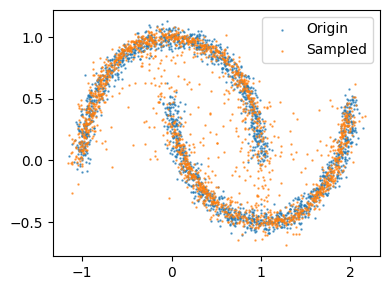

In [4]:
# Generate and visualize
with torch.no_grad():
    x_samples = model.generate(n_samples=2000, n_steps=10000, device=device)

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    ax.scatter(X[:, 0].cpu(), X[:, 1].cpu(), alpha=0.7, s=0.5, label='Origin')
    ax.scatter(x_samples[:, 0].cpu(), x_samples[:, 1].cpu(), alpha=0.7, s=0.5, label='Sampled')

    ax.legend()
    plt.tight_layout()
    plt.show()